In [1]:
#lib import
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import dataset
telecom_df = pd.read_csv("telecom_churn_data.csv")
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
telecom_df.shape

(99999, 226)

In [5]:
# Filter High value Customers
# High-value customers : Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of average recharge amount in the first two months.

# lets find out total amount spent by customers on data recharge,we have two colums available to find this out 
# First column is av_rech_amt_data_x (x represents month here, would be either 6 or 7 or 8)
# Second column is total_rech_data_x (x represnts month here, would be either 6 or 7 or 8)
# Lets introduce a new column total_rech_data_amt_x which can be calculated as av_rech_amt_data_x * total_rech_data_x

In [6]:
telecom_df['total_rech_data_amt_6'] = telecom_df['av_rech_amt_data_6'] * telecom_df['total_rech_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['av_rech_amt_data_7'] * telecom_df['total_rech_data_7']
telecom_df['total_rech_data_amt_8'] = telecom_df['av_rech_amt_data_8'] * telecom_df['total_rech_data_8']
telecom_df['total_rech_data_amt_9'] = telecom_df['av_rech_amt_data_9'] * telecom_df['total_rech_data_9']

# We dont require columns av_rech_amt_data_x,total_rech_data_x (x = 6/7/8) so drop them:

telecom_df.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)


In [7]:
# Find the average recharge done in the first two months(June & July), the good phase
# total amount spend would be the sum of total data recharge done & total call/sms recharges
telecom_av_rech = (telecom_df['total_rech_amt_6'].fillna(0) 
+ telecom_df['total_rech_amt_7'].fillna(0) 
+ telecom_df['total_rech_data_amt_6'].fillna(0) 
+ telecom_df['total_rech_data_amt_7'].fillna(0))/2

In [8]:
# 70 percentile of  calculated average amount
percentile_70 = np.percentile(telecom_av_rech, 70.0)
print("70 percentile : ", percentile_70)

# Fitler the data based on 70th percentile
telecom_hv_cust = telecom_df[telecom_av_rech >= percentile_70]

print("Dimensions of filtered dataset:",telecom_hv_cust.shape)

70 percentile :  478.0
Dimensions of filtered dataset: (30001, 222)


In [9]:
#Adding a new column "churn" with values 1 (churn) or 0 (non-churn) and calculate churn/non-churn:

telecom_hv_cust['churn'] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_hv_cust.head(10)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0
33,7000149764,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,977.020,...,1328,358.10,2706.83,1714.67,0.00,5285.0,20424.0,455.0,1814.0,0
38,7000815202,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,363.987,...,1155,0.00,0.00,0.00,0.00,NaN,NaN,NaN,207.0,0
41,7000721289,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,482.832,...,2010,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
48,7000294396,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1873.271,...,1265,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
53,7002188521,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,978.077,...,697,0.00,0.00,0.00,0.00,344.0,575.0,23.0,92.0,0


In [10]:
#finding churn/non churn percentage
telecom_hv_cust['churn'].value_counts()/len(telecom_hv_cust)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

In [11]:
#91.8 % of the customers do not churn, it might be class imbalance, we will treat that later in solution.

In [12]:
#check columns with no variance in their values and drop such columns
for i in telecom_hv_cust.columns:
    if telecom_hv_cust[i].nunique() == 1:
        print("\nColumn",i,"no variance and contains only", telecom_hv_cust[i].nunique(),"unique value")
        print("Drop column",i)
        telecom_hv_cust.drop(i,axis=1,inplace = True)

print("\nDimensions of updated dataset:",telecom_hv_cust.shape)


Column circle_id no variance and contains only 1 unique value
Drop column circle_id

Column loc_og_t2o_mou no variance and contains only 1 unique value
Drop column loc_og_t2o_mou

Column std_og_t2o_mou no variance and contains only 1 unique value
Drop column std_og_t2o_mou

Column loc_ic_t2o_mou no variance and contains only 1 unique value
Drop column loc_ic_t2o_mou

Column last_date_of_month_6 no variance and contains only 1 unique value
Drop column last_date_of_month_6

Column last_date_of_month_7 no variance and contains only 1 unique value
Drop column last_date_of_month_7

Column last_date_of_month_8 no variance and contains only 1 unique value
Drop column last_date_of_month_8

Column last_date_of_month_9 no variance and contains only 1 unique value
Drop column last_date_of_month_9

Column std_og_t2c_mou_6 no variance and contains only 1 unique value
Drop column std_og_t2c_mou_6

Column std_og_t2c_mou_7 no variance and contains only 1 unique value
Drop column std_og_t2c_mou_7

Col

In [13]:
#New dimensions are (30001,207)

In [14]:
#check for null
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

arpu_3g_9                   49.268358
fb_user_9                   49.268358
date_of_last_rech_data_9    49.268358
max_rech_data_9             49.268358
count_rech_2g_9             49.268358
                              ...    
max_rech_amt_8               0.000000
max_rech_amt_7               0.000000
max_rech_amt_6               0.000000
total_rech_amt_9             0.000000
churn                        0.000000
Length: 207, dtype: float64

In [15]:
# Drop Columns with > 40% of missing values except 9th Month's columns
cols = telecom_hv_cust.columns
telecom_null = telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)
telecom_null_df = pd.DataFrame({'col_name': cols,'perc_null': telecom_null})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 40.0)]["col_name"]
print("list of columns dropped:",drop_cols)

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

In [16]:
# lets drop these columns
telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)

In [17]:
telecom_hv_cust.shape

(30001, 180)

In [18]:
#Cols dropped to 180 from 207
#Columns that can be changed to integers, floats or date types
object_col = telecom_hv_cust.select_dtypes(include=['object'])
print(object_col.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [19]:
#Convert to datetime
for col in object_col.columns:
    telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])

telecom_hv_cust.shape

(30001, 180)

In [20]:
#Checking correlation to drop the highly correlated features:
corr = telecom_hv_cust.corr()
corr.loc[:,:] = np.tril(corr, k=-1)
corr = corr.stack()
corr[(corr > 0.60) | (corr < -0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

In [21]:
# we will drop the columns with high correlation (+/- 60%)
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']

In [22]:
telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)
telecom_hv_cust.shape

(30001, 125)

In [23]:
#Deleting 9th month columns because churn/non-churn will be predicted later based on data from the 1st 3 months
cols_to_drop = [col for col in telecom_hv_cust.columns if '_9' in col]
print(cols_to_drop)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_rech_data_amt_9']


In [24]:
telecom_hv_cust.drop(cols_to_drop, axis=1, inplace=True)
telecom_hv_cust.shape

(30001, 88)

In [25]:
#check for null again
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

loc_og_t2c_mou_8      3.913203
roam_ic_mou_8         3.913203
spl_og_mou_8          3.913203
isd_og_mou_8          3.913203
std_og_mou_8          3.913203
                        ...   
last_day_rch_amt_7    0.000000
last_day_rch_amt_8    0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
churn                 0.000000
Length: 88, dtype: float64

In [26]:
# Drop rows with null values
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_8'])]

In [27]:
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)
#All null values handled

mobile_number         0.0
arpu_6                0.0
last_day_rch_amt_6    0.0
max_rech_amt_8        0.0
max_rech_amt_7        0.0
                     ... 
std_og_mou_8          0.0
std_og_mou_7          0.0
std_og_mou_6          0.0
std_og_t2f_mou_8      0.0
churn                 0.0
Length: 88, dtype: float64

In [28]:
# function to plot correlation matrix:

In [29]:
def plotCorrMat(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [30]:
# function to plot scatter plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
         ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [31]:
# calling the function to plot the graphs

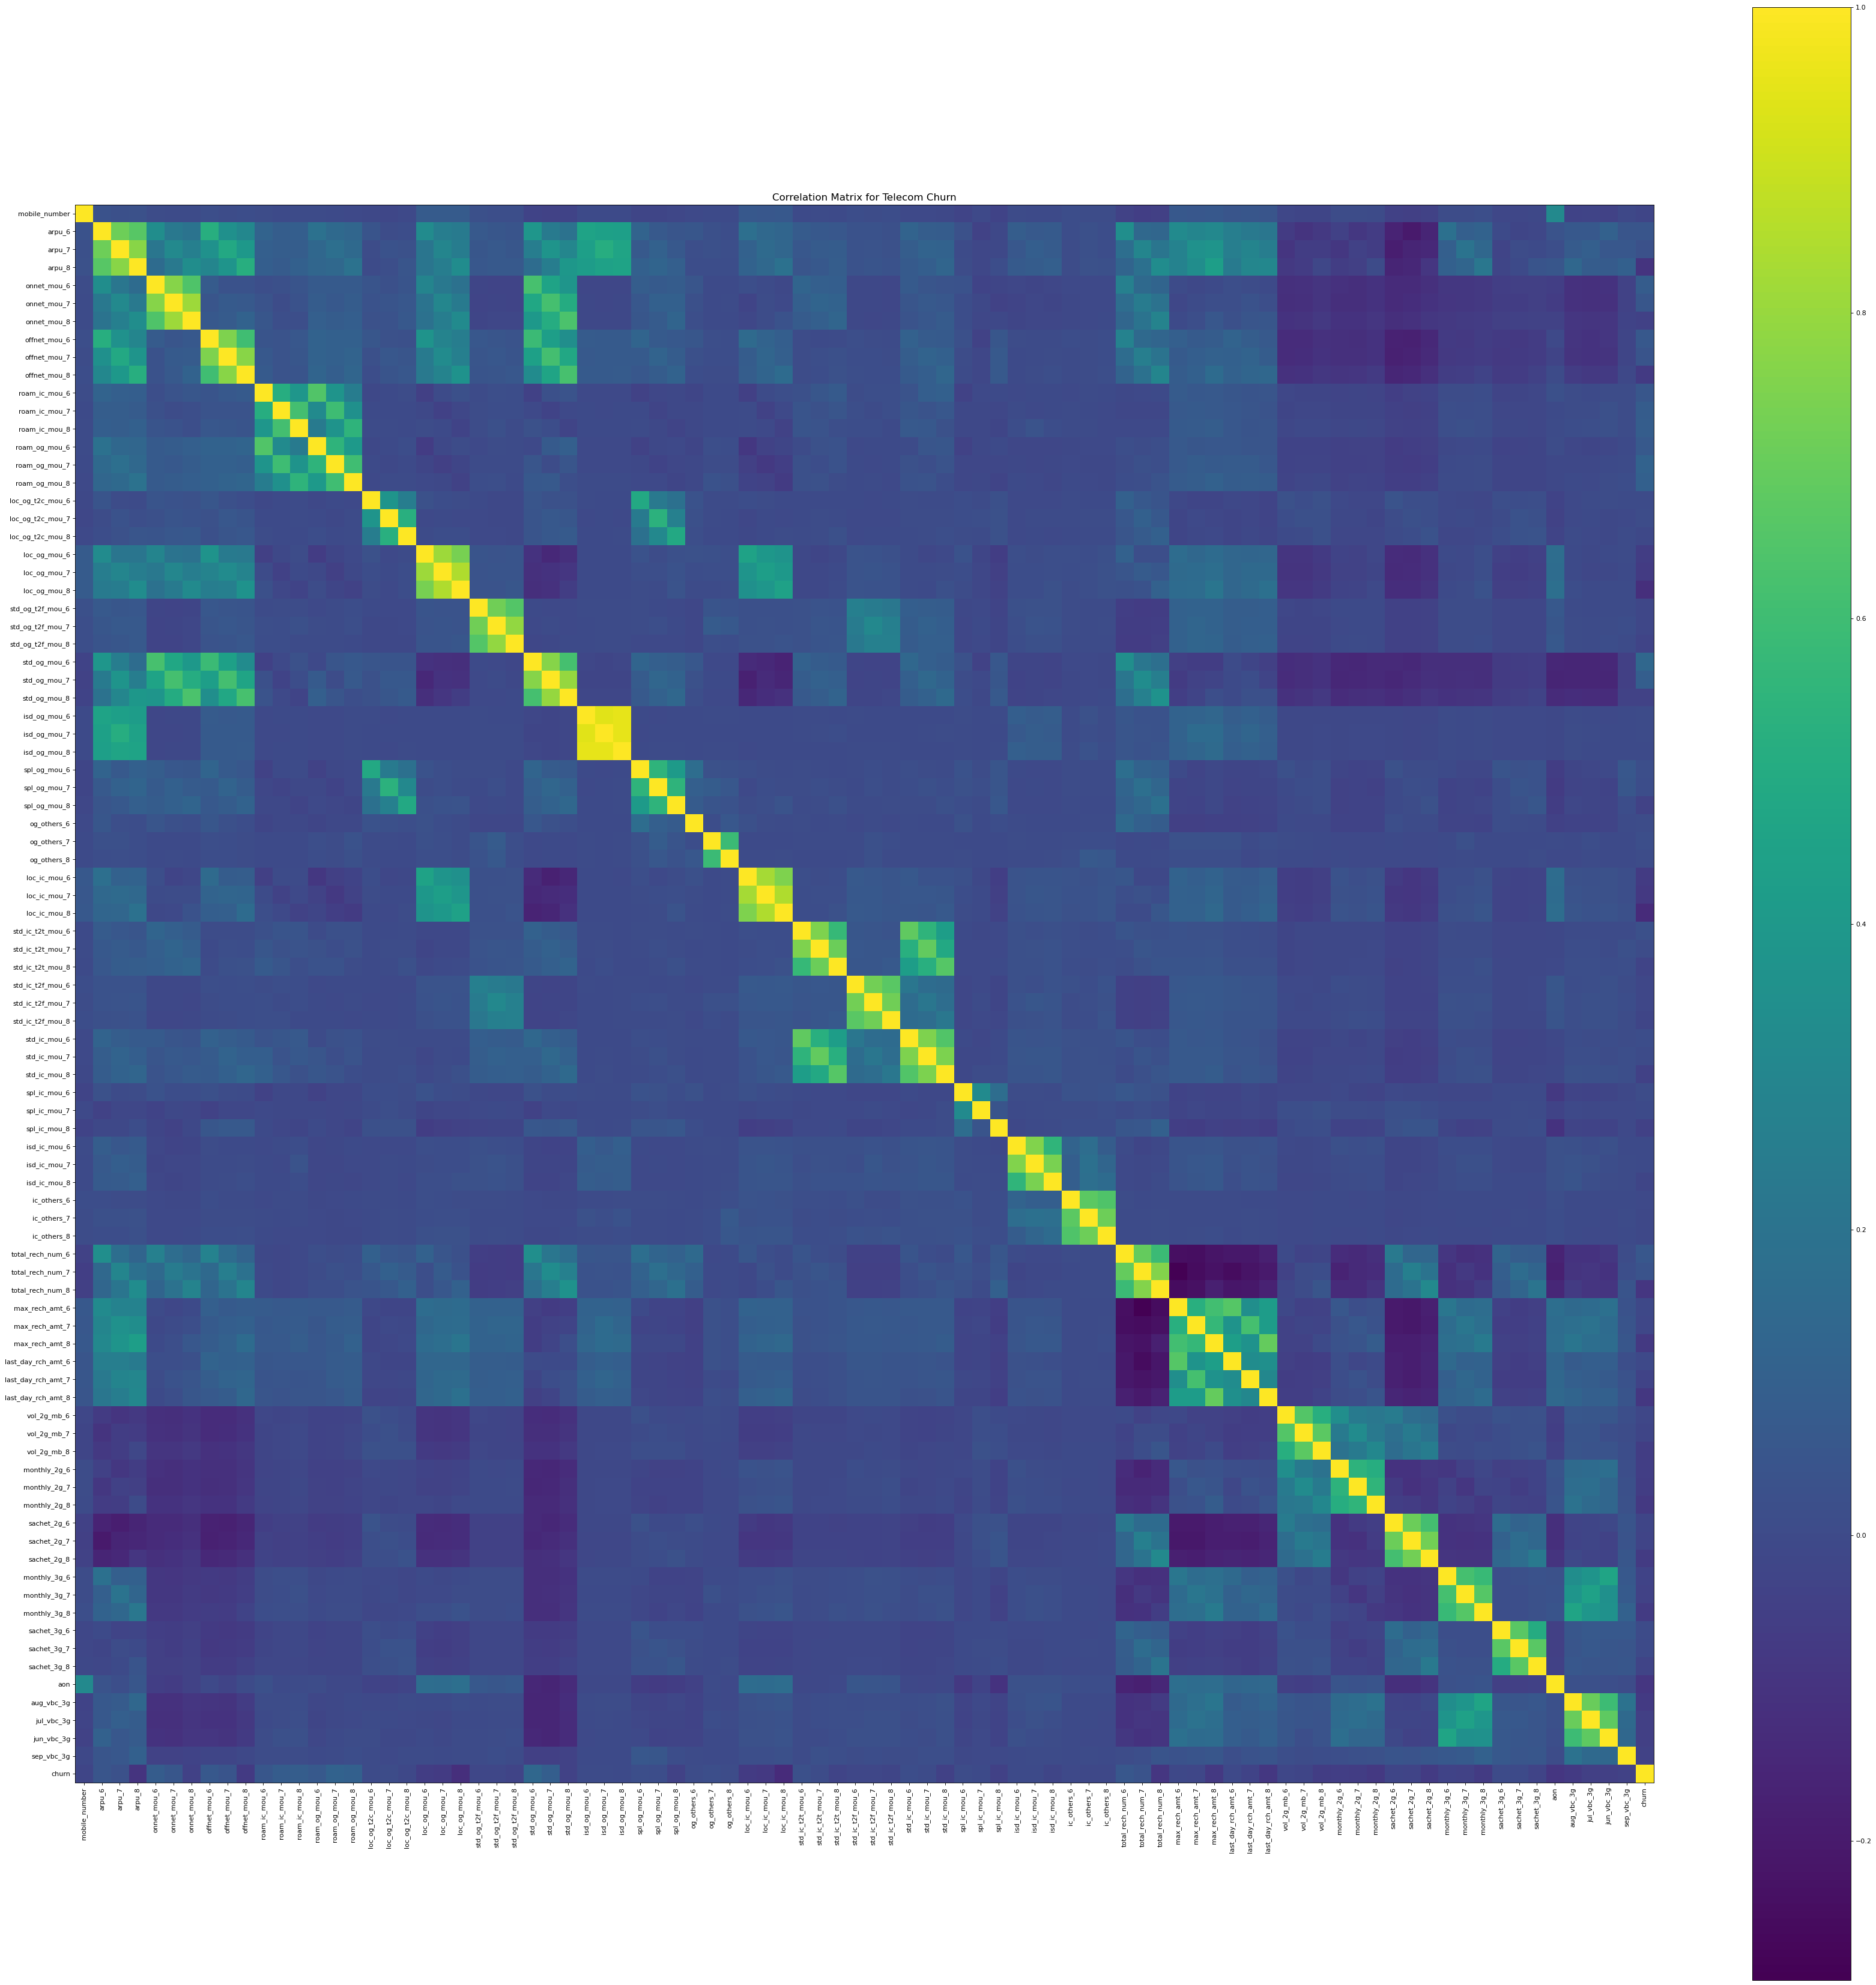

In [32]:
plotCorrMat(telecom_hv_cust, 53)

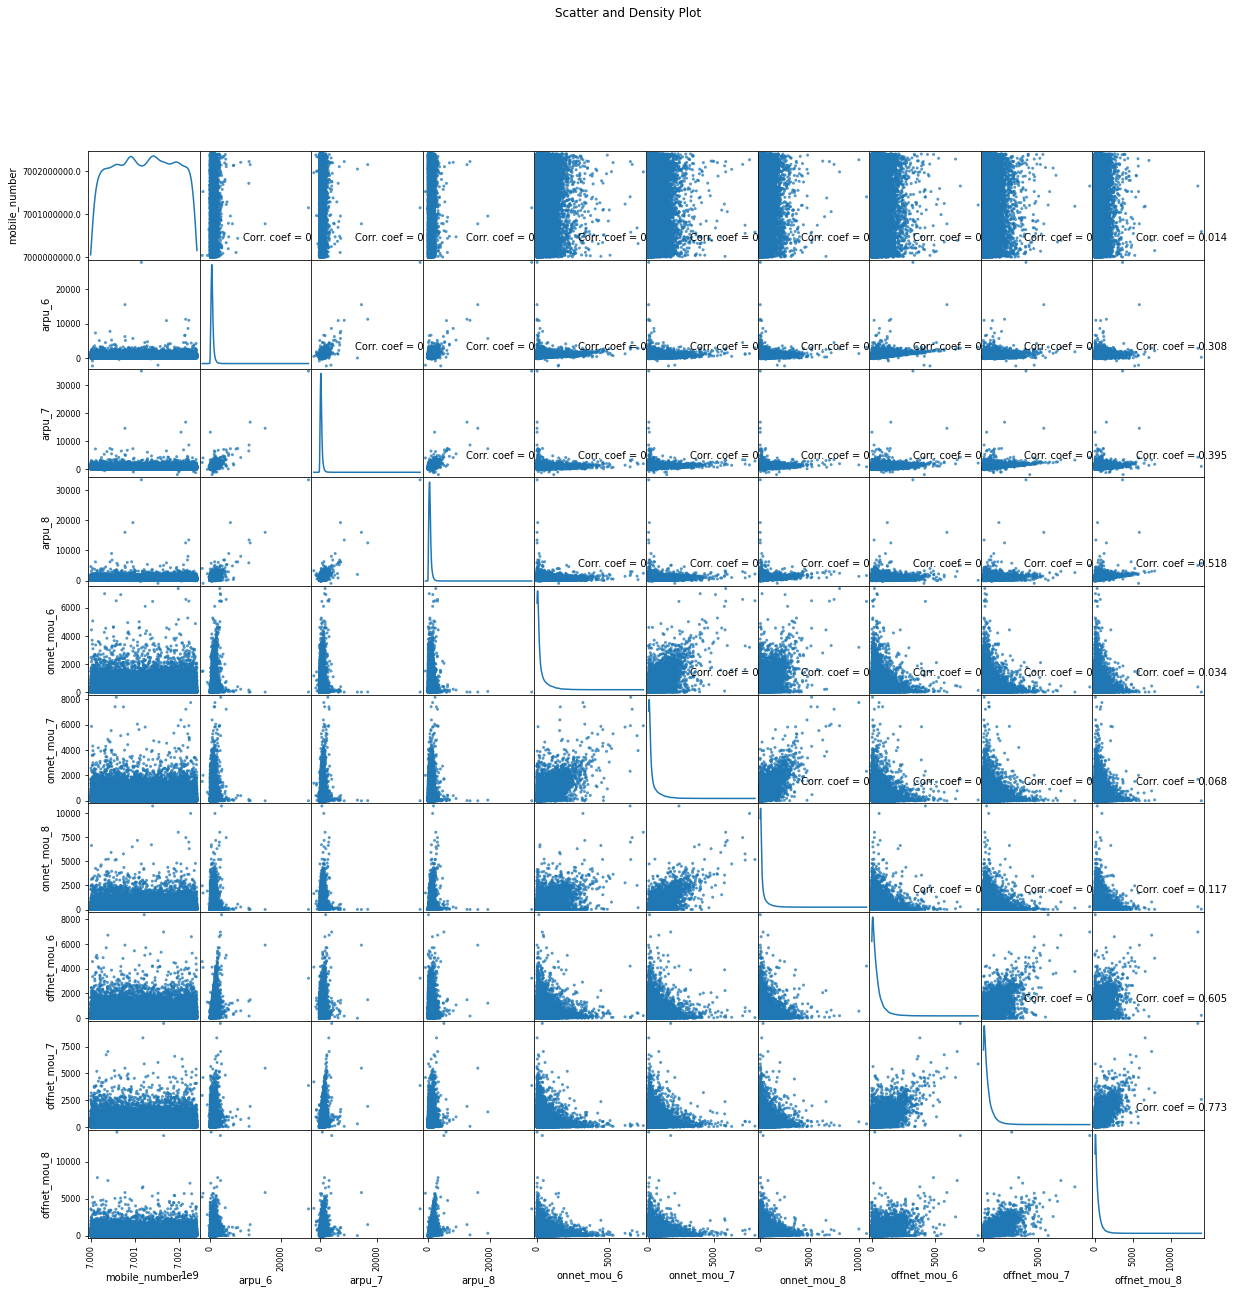

In [33]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

In [34]:
#Derive some new feautres from the existing columns
col_list = telecom_hv_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_hv_cust.shape)

# lets take the average now
for idx, col in enumerate(col_list.unique()):
    avg_col_name = "avg_"+col+"_av67" # lets create the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_hv_cust[avg_col_name] = (telecom_hv_cust[col_6]  + telecom_hv_cust[col_7])/ 2
# created a new colulmn, which would be average  of 6th & 7th months

(28504, 88)


In [35]:
#columns to drop
print ("dimension of updated dataset after creating dervied features:",telecom_hv_cust.shape)
col_drop = telecom_hv_cust.filter(regex='_6|_7').columns
telecom_hv_cust.drop(col_drop, axis=1, inplace=True)

print("dimension of dataset after dropping un-necessary columns:",telecom_hv_cust.shape)

dimension of updated dataset after creating dervied features: (28504, 115)
dimension of dataset after dropping un-necessary columns: (28504, 61)


In [36]:
# conevrt AON in months
telecom_hv_cust['aon_mon'] = telecom_hv_cust['aon']/30
telecom_hv_cust.drop('aon', axis=1, inplace=True)
telecom_hv_cust['aon_mon'].head()

7     26.733333
8     10.500000
21    24.000000
23    20.133333
33    44.266667
Name: aon_mon, dtype: float64

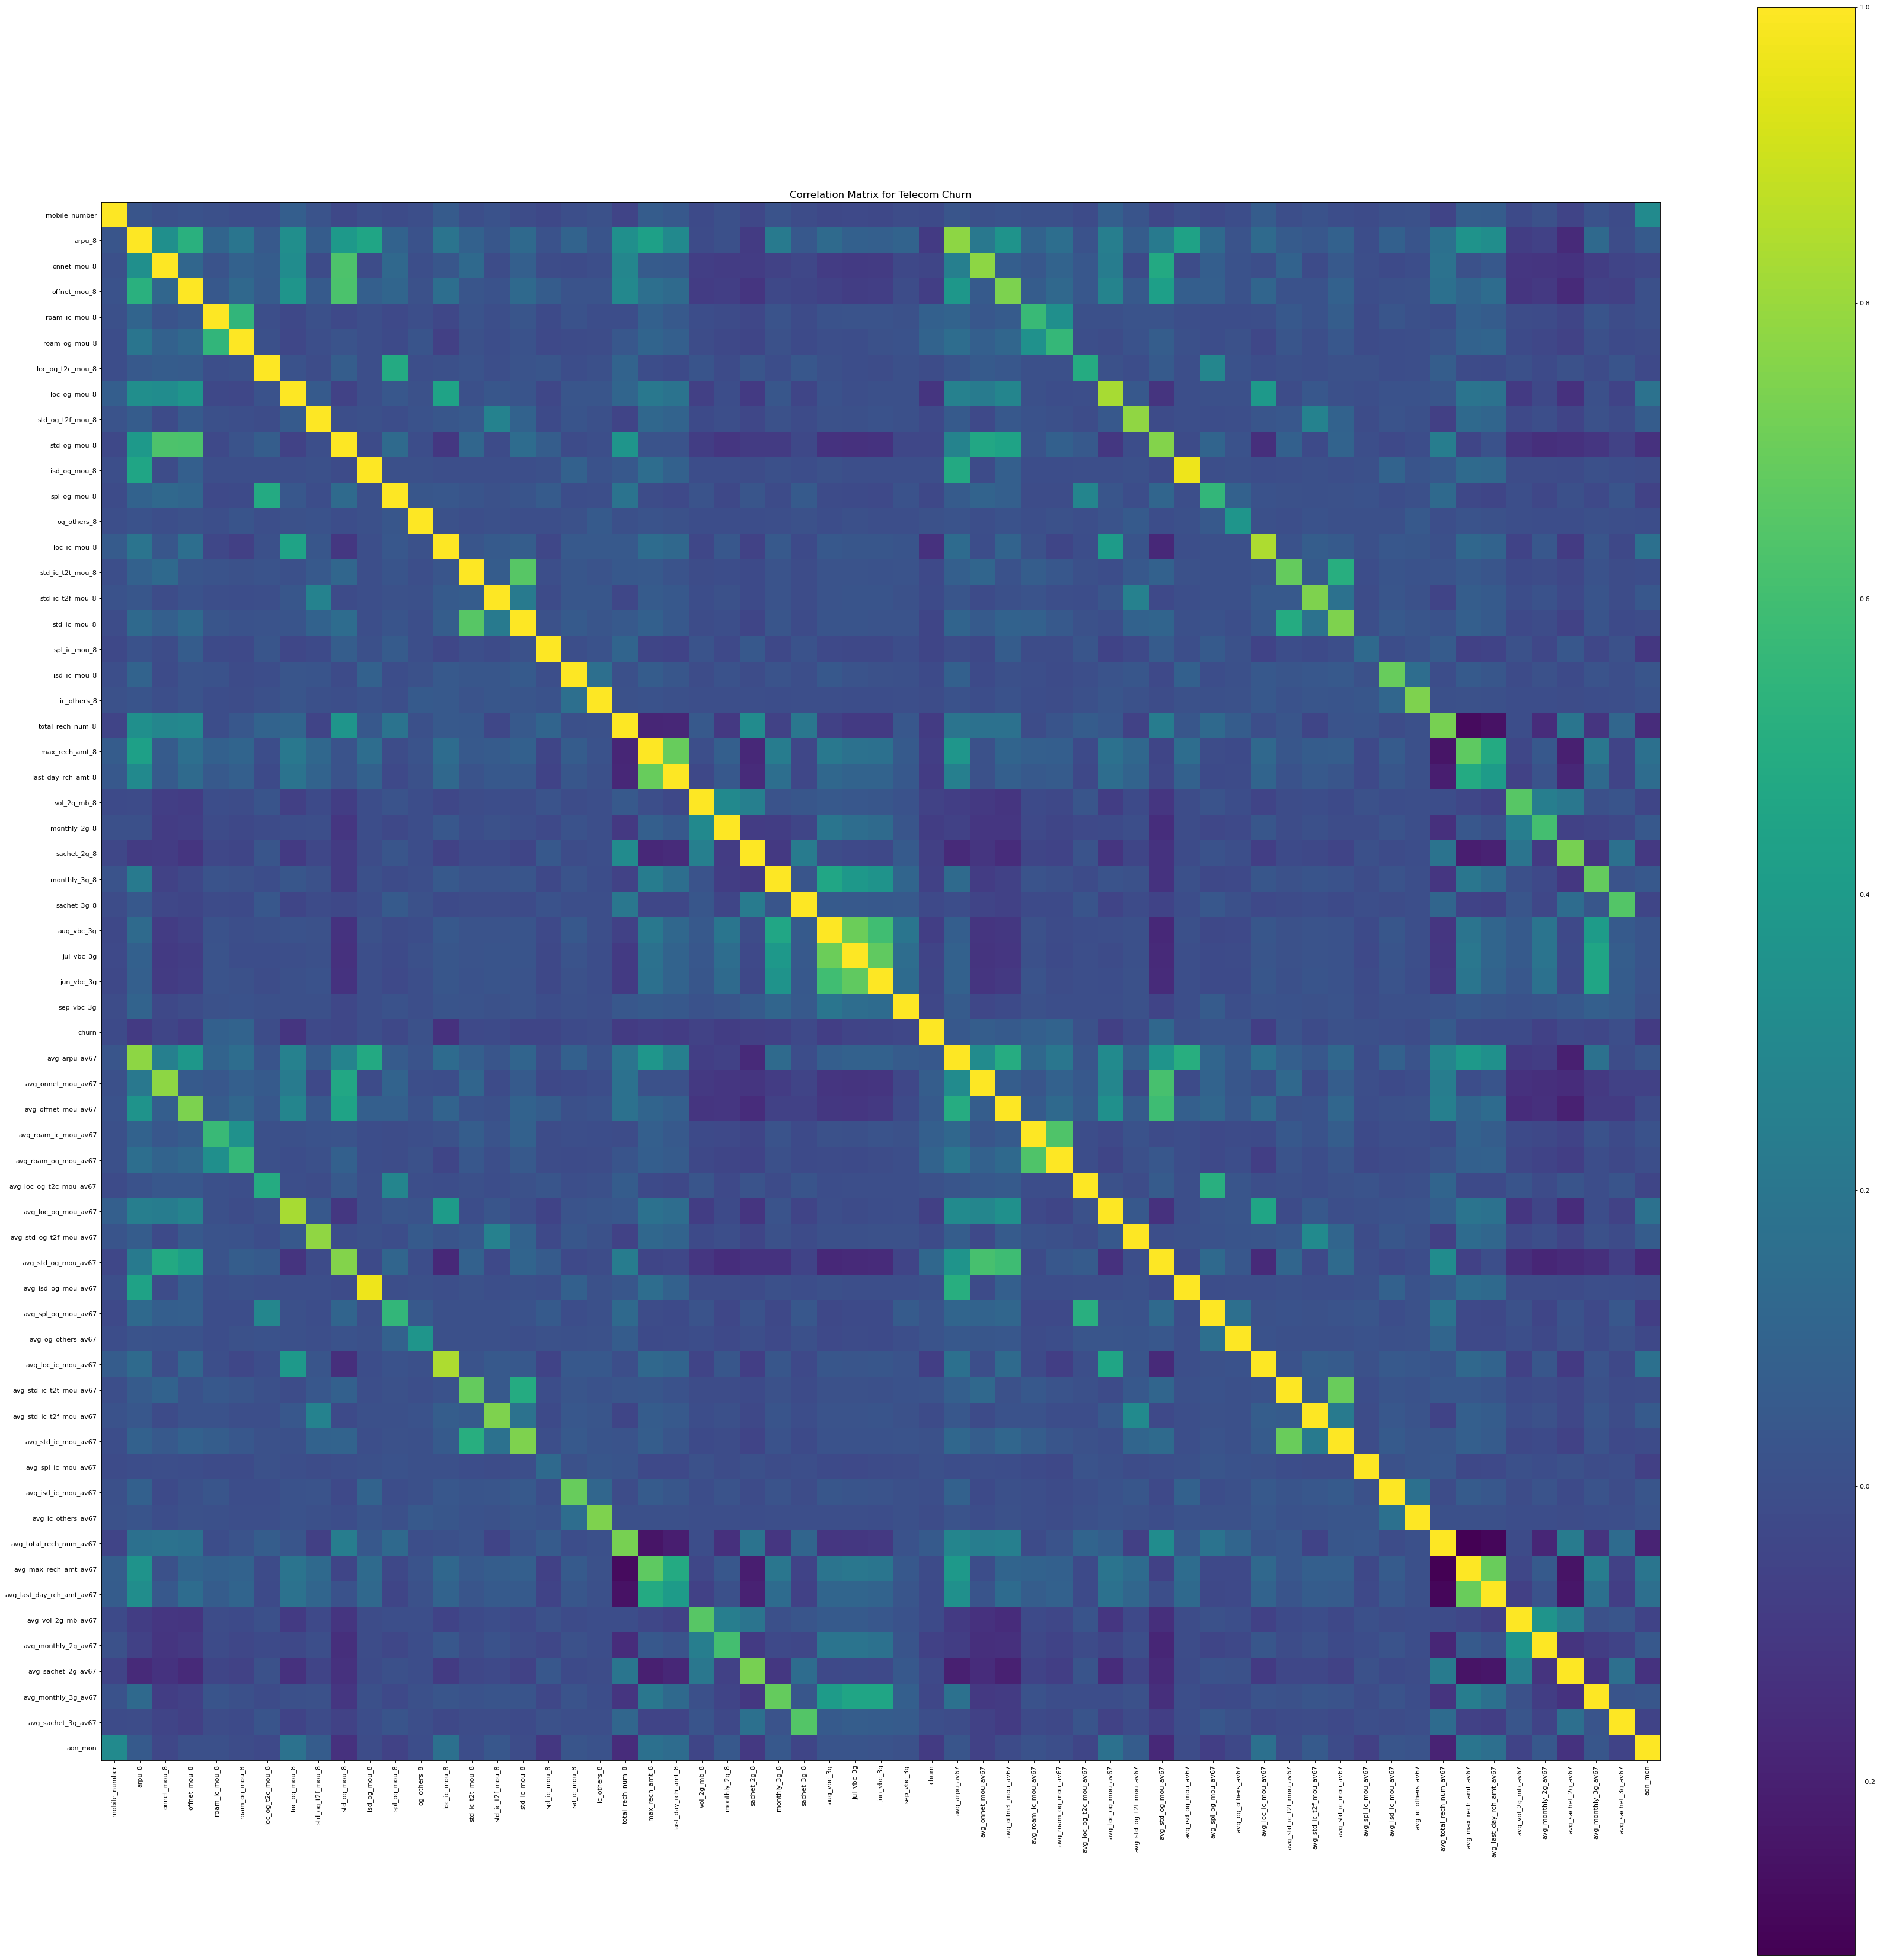

In [37]:
plotCorrMat(telecom_hv_cust, 53)

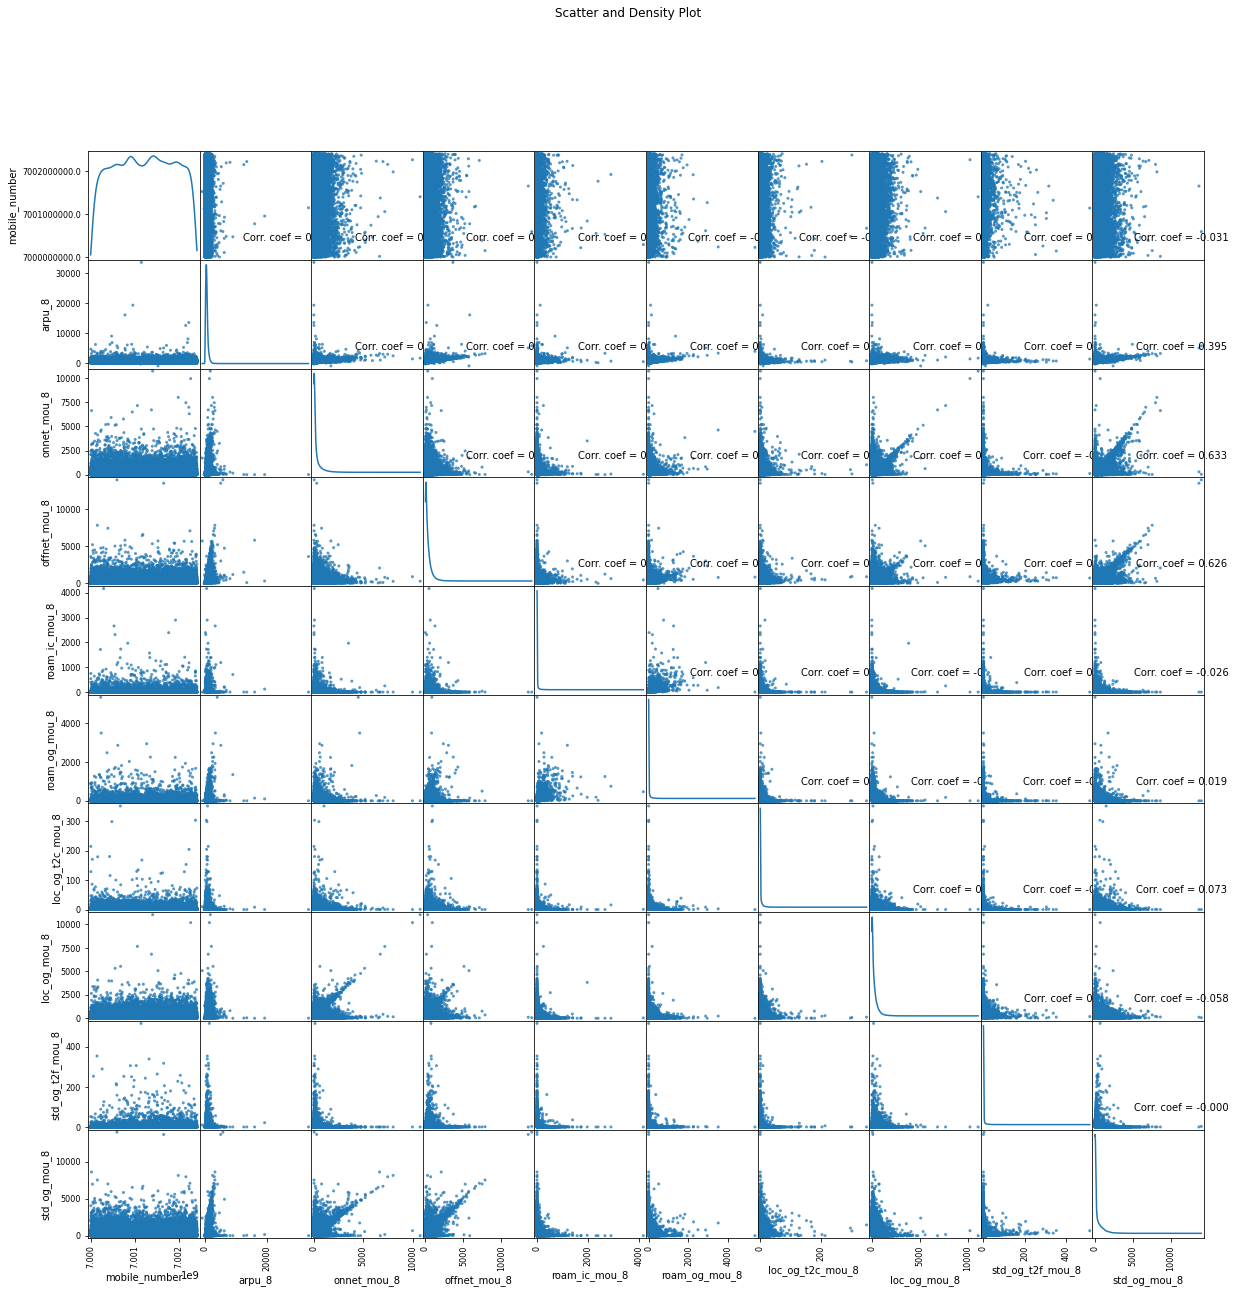

In [38]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

Text(0.5, 1.0, 'Tenure Graph')

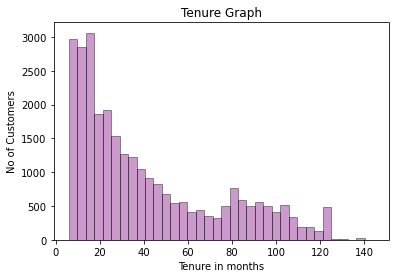

In [39]:
ax = sns.distplot(telecom_hv_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 10})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure in months')
ax.set_title('Tenure Graph')
# Graph showing the tenure of the customers

In [40]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_hv_cust['tenure_range'] = pd.cut(telecom_hv_cust['aon_mon'], tn_range, labels=tn_label)
telecom_hv_cust['tenure_range'].head(10)

7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
33        2-5 Yrs
38        2-5 Yrs
41            NaN
48        2-5 Yrs
53        1-2 Yrs
56        2-5 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

<AxesSubplot:>

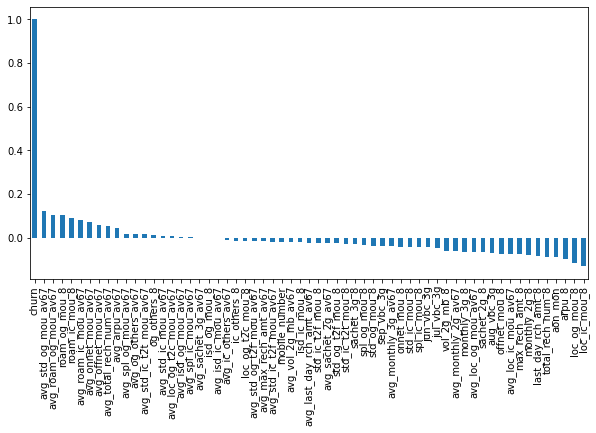

In [41]:
#Checking correlation of churn with other columns
plt.figure(figsize=(10,5))
telecom_hv_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')


In [42]:
#  Avg Outgoing Calls & calls on romaning for 6 & 7th months are positively correlated with churn. 
#  Avg Revenue, No. Of Recharge for 8th month has negative correlation with churn.

<AxesSubplot:xlabel='total_rech_num_8', ylabel='arpu_8'>

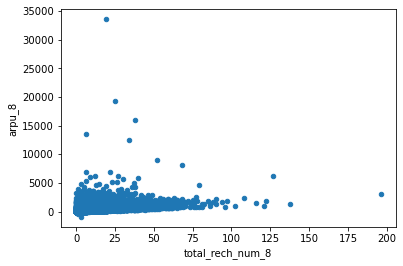

In [43]:
telecom_hv_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8', y='arpu_8')
#scatter plot between total recharge and avg revenue for the 8th month

<AxesSubplot:xlabel='aon_mon', ylabel='avg_arpu_av67'>

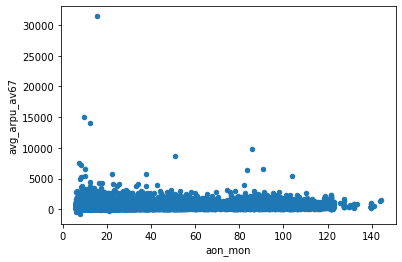

In [44]:
telecom_hv_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon', y='avg_arpu_av67')

<AxesSubplot:xlabel='churn', ylabel='aon_mon'>

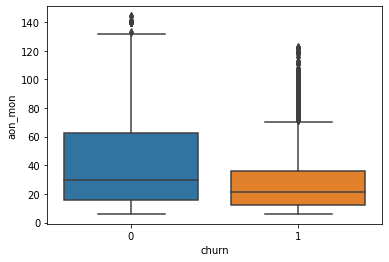

In [45]:
#Churn Vs other important features
sns.boxplot(x = telecom_hv_cust.churn, y = telecom_hv_cust.aon_mon)

Text(0.5, 1.0, 'Churn Vs Base Cost')

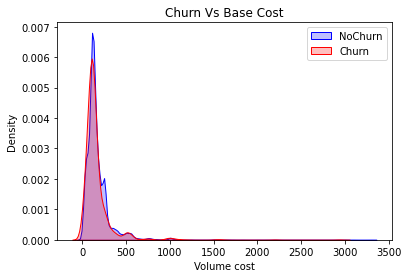

In [46]:
# Tenured customers do no churn
# churn Vs Base Cost
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 0)],
                color="Blue", shade = True)
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Red", shade= True)
ax.legend(["NoChurn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume cost')
ax.set_title('Churn Vs Base Cost')

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

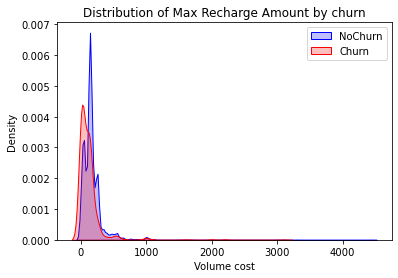

In [47]:
# churn vs max rechare amount
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 0)],
                color="Blue", shade = True)
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Red", shade= True)
ax.legend(["NoChurn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

In [48]:
# Creating new dataset for model building
df = telecom_hv_cust[:].copy()

# Drop tenure range because it is highly correlated with AON MONTH column
df.drop('tenure_range', axis=1, inplace=True)
df.drop('mobile_number', axis=1, inplace=True)
df.head(10)

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,aon_mon
7,3171.480,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,...,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0,26.733333
8,137.362,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,...,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0,10.500000
21,637.760,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,...,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0,24.000000
23,366.966,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,...,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0,20.133333
33,409.230,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,...,0.940,10.5,753.5,126.0,72.405,0.0,0.0,4.5,2.0,44.266667
38,393.909,666.38,97.81,0.00,0.00,0.00,28.44,0.00,735.74,0.00,...,0.000,24.5,70.0,20.0,0.000,0.0,0.0,0.0,0.0,38.500000
41,229.769,80.44,136.69,0.00,0.00,0.00,203.21,13.18,13.18,0.74,...,0.280,4.0,150.0,150.0,0.000,0.0,0.0,0.0,0.0,67.000000
48,179.218,156.91,68.18,0.00,0.00,0.00,95.69,0.00,129.39,0.00,...,0.000,9.0,250.0,180.0,0.000,0.0,0.0,0.0,0.0,42.166667
53,706.020,102.69,261.34,0.00,0.00,0.00,241.61,0.00,5.23,117.19,...,0.000,25.0,135.0,65.0,0.135,0.0,4.5,0.0,0.0,23.233333
56,368.807,50.61,84.31,0.00,0.00,4.48,128.51,0.00,1.93,0.00,...,0.000,18.5,92.0,25.0,366.600,1.0,6.0,0.0,0.0,24.300000


In [49]:
# Creating X & y dataset for model building, X will not have "churn" and y will only have "churn"
X = df.drop(['churn'], axis=1)
y = df['churn']

df.drop('churn', axis=1, inplace=True)

In [50]:
#scaling on the dataset

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [51]:
# Splitting dateset into train and test"


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (19952, 59)
Dimension of X_test: (8552, 59)


In [52]:
#Lets balance the dataset
!pip install imbalanced-learn==0.6.0
!pip install scikit-learn==0.22.1

  Using cached scikit-learn-0.22.1.tar.gz (6.9 MB)
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
    Running setup.py install for scikit-learn: started
    Running setup.py install for scikit-learn: finished with status 'error'
  Rolling back uninstall of scikit-learn
  Moving to c:\users\heman\anaconda3\lib\site-packages\scikit_learn-1.0.2.dist-info\
   from C:\Users\heman\anaconda3\Lib\site-packages\~cikit_learn-1.0.2.dist-info
  Moving to c:\users\heman\anaconda3\lib\site-packages\sklearn\
   from C:\Users\heman\anaconda3\Lib\site-packages\~klearn


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\heman\anaconda3\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\heman\\AppData\\Local\\Temp\\pip-install-ntwhy3hs\\scikit-learn_66c2fb7434be4d28bb6838babad1a736\\setup.py'"'"'; __file__='"'"'C:\\Users\\heman\\AppData\\Local\\Temp\\pip-install-ntwhy3hs\\scikit-learn_66c2fb7434be4d28bb6838babad1a736\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\heman\AppData\Local\Temp\pip-wheel-58qvxxk8'
       cwd: C:\Users\heman\AppData\Local\Temp\pip-install-ntwhy3hs\scikit-learn_66c2fb7434be4d28bb6838babad1a736\
  Complete output (35 lines):
  Partial import of sklearn during the build process.
  No module named 'numpy.distutils._msvccompi

In [53]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_tr,y_tr = sm.fit_sample(X_train,y_train)

In [54]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)

print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

Dimension of X_tr Shape: (37666, 59)
Dimension of y_tr Shape: (37666,)
Imbalance in Training dataset: 1.0


In [55]:
# Model Building
# SVM (lets start with linear SVM)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

lr = LogisticRegression()

lr.svm = SVC(kernel='linear') 
lr.svm.fit(X_train,y_train)
preds = lr.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

# linear SVM gave us accuracy of 94% on test data

0.9419400105244694

In [56]:
# RFE for feature reduction


lr = LogisticRegression()

# RFE  to select 15 most imp features
rfe = RFE(lr,n_features_to_select=15)   
rfe = rfe.fit(X_tr, y_tr)

In [57]:
rfe_features = list(df.columns[rfe.support_])
print("15 RFE features: ", rfe_features)

15 RFE features:  ['onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'spl_ic_mou_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sep_vbc_3g', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'aon_mon']


In [58]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

In [59]:
#Logisctic Regression model on the seleted columns by RFE

lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [60]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)


confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print('Accuracy on test:',lr.score(X_test_rfe, y_test))
#Accuracy on Test Dataset comes to be 78% (good)

[[4223 1147]
 [  62  269]]
Accuracy on test: 0.7879319417646027


In [61]:
 #Checking classification report on the test dataset

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.79      0.87      5370
           1       0.19      0.81      0.31       331

    accuracy                           0.79      5701
   macro avg       0.59      0.80      0.59      5701
weighted avg       0.94      0.79      0.84      5701



In [62]:
#Confusion matix shows high false positive rate that is not good, lets try PCA:

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# Apply SMOTE to correct class imbalance

sm = SMOTE(random_state=0)
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(37666, 59)
(37666,)


In [64]:
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

#PCA on train data
pca.fit(X_tr)

PCA(random_state=100)

In [65]:
X_tr_PCA = pca.fit_transform(X_tr)
print(X_tr_PCA.shape)

(37666, 59)


In [66]:
X_test_PCA = pca.transform(X_test)
print(X_test_PCA.shape)

(8552, 59)


In [67]:
lr_PCA = LogisticRegression(C=1e9)
lr_PCA.fit(X_tr_PCA, y_tr)

LogisticRegression(C=1000000000.0)

In [68]:
# making predictions
y_pred = lr_PCA.predict(X_test_PCA)

In [69]:
#array into a dataframe
y_pred_df = pd.DataFrame(y_pred)

In [70]:
#Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print("Accuracy of logistic regression with PCA: ",accuracy_score(y_test,y_pred))
#Accuracy - 80%

[[6494 1581]
 [  93  384]]
Accuracy of logistic regression with PCA:  0.8042563143124415


In [71]:
col = list(df.columns)
df_PCA = pd.DataFrame({'PC-1':pca.components_[0],'PC-2':pca.components_[1], 'PC-3':pca.components_[2],'Feature':col})
df_PCA.head(20)

,PC-1,PC-2,PC-3,Feature
0,0.187802,0.240122,0.137407,arpu_8
1,0.077026,0.203392,-0.093642,onnet_mou_8
2,0.126008,0.219707,0.002430,offnet_mou_8
3,0.410293,-0.223232,-0.065486,roam_ic_mou_8
4,0.367866,-0.119792,-0.080316,roam_og_mou_8
5,0.015446,0.063880,-0.028041,loc_og_t2c_mou_8
6,0.039852,0.152159,0.151593,loc_og_mou_8
7,0.025954,0.037975,0.073708,std_og_t2f_mou_8
8,0.065978,0.246759,-0.150927,std_og_mou_8
9,0.052767,0.089162,0.087791,isd_og_mou_8


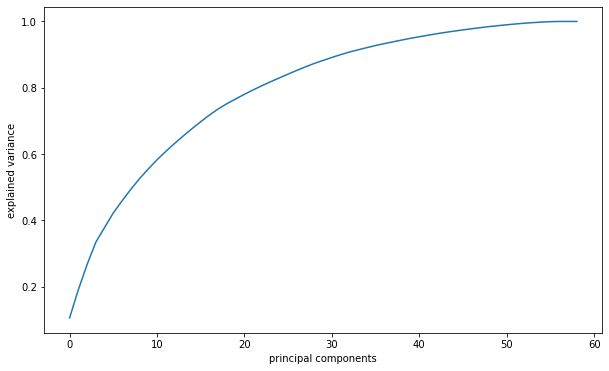

In [72]:
pltt = plt.figure(figsize = (10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('principal components')
plt.ylabel('explained variance')
plt.show()
#Variance by PCA

In [73]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=5)*100)
#27 cols with 90% variance

array([ 10.557,  19.06 ,  26.654,  33.393,  37.848,  42.238,  45.876,
        49.348,  52.589,  55.513,  58.267,  60.802,  63.193,  65.463,
        67.657,  69.76 ,  71.78 ,  73.633,  75.216,  76.635,  78.038,
        79.366,  80.624,  81.831,  82.994,  84.138,  85.26 ,  86.341,
        87.358,  88.26 ,  89.154,  89.993,  90.774,  91.452,  92.108,
        92.759,  93.316,  93.866,  94.404,  94.93 ,  95.401,  95.86 ,
        96.307,  96.72 ,  97.097,  97.466,  97.813,  98.143,  98.466,
        98.738,  99.003,  99.249,  99.478,  99.654,  99.822,  99.951,
       100.002, 100.002, 100.002])

In [74]:
# PCA with 27 components
#pca_27 = PCA(n_components=27)

#df_tr_pca_27 = pca_27.fit_transform(X_tr)
#print(df_tr_pca_27.shape)

#df_test_pca_27 = pca_27.transform(X_test)
#print(df_test_pca_27.shape)

In [75]:
# Running the model using the selected variables
#from sklearn.linear_model import LogisticRegression
#from sklearn import metrics
#lr_pca1 = LogisticRegression(C=1e9)
#lr_pca1.fit(df_tr_pca_27, y_tr)

# Predicted probabilities
#y_pred27 = lr_pca1.predict(df_test_pca_27)

# Converting y_pred to a dataframe which is an array
#df_y_pred = pd.DataFrame(y_pred27)

#print("Accuracy 27 PCA: ",accuracy_score(y_test,y_pred27))

In [76]:
#print(confusion_matrix(y_test,y_pred27))



#Model has 80% Accuracy 27 features can explain 90% variance in the dataset.
#Imp features: arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8.

In [77]:
#Decision Tree
# lets create a decision tree now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(37666, 59)
(37666,)


In [78]:
# feature selection using lasso
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

(37666, 34)
[ 0  3  4  6  7  8 10 12 15 16 19 21 22 23 24 25 26 27 30 31 32 33 34 35
 39 43 44 46 50 51 53 54 55 58]


In [79]:
lasso_features = list(df.columns[position])
print("Lasso Features: ", lasso_features)

Lasso Features:  ['arpu_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aug_vbc_3g', 'sep_vbc_3g', 'avg_arpu_av67', 'avg_onnet_mou_av67', 'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'avg_std_ic_t2t_mou_av67', 'avg_std_ic_mou_av67', 'avg_total_rech_num_av67', 'avg_max_rech_amt_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'avg_sachet_2g_av67', 'aon_mon']


In [80]:
# Decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Create a decision tree with the default hyper parameter
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5)

In [81]:
# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      8075
           1       0.24      0.74      0.36       477

    accuracy                           0.85      8552
   macro avg       0.61      0.80      0.64      8552
weighted avg       0.94      0.85      0.88      8552



In [82]:
# Confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of Decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))
#Decision Tree accuracy: 85%

[[6925 1150]
 [ 122  355]]
Decision Tree - Accuracy : 0.8512628624883068


In [83]:
#Fine tune hyperparameters
# GridSearchCV to find optimal max_depth

n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

In [84]:
# Instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# Fit tree 
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [87]:
Scr = tree.cv_results_
pd.DataFrame(Scr).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.114481,0.004075,0.002834,0.000425,1,{'max_depth': 1},0.771834,0.800478,0.802867,0.795433,...,0.794908,0.011903,39,0.800710,0.793515,0.792951,0.794810,0.792686,0.794934,0.002979
1,0.201413,0.014491,0.001796,0.000399,2,{'max_depth': 2},0.809530,0.817603,0.826364,0.822249,...,0.821325,0.007355,38,0.827393,0.822354,0.826071,0.821325,0.822056,0.823840,0.002421
2,0.295312,0.013949,0.002204,0.000757,3,{'max_depth': 3},0.825458,0.838444,0.843887,0.844152,...,0.840387,0.008311,37,0.841896,0.845286,0.841337,0.844290,0.842133,0.842988,0.001525
3,0.373392,0.007738,0.002303,0.000386,4,{'max_depth': 4},0.834749,0.850923,0.858091,0.851719,...,0.852016,0.009946,36,0.856399,0.857565,0.855474,0.855308,0.852753,0.855500,0.001591
4,0.461387,0.010222,0.002194,0.000399,5,{'max_depth': 5},0.839793,0.862206,0.868446,0.863534,...,0.860538,0.010691,35,0.870304,0.870341,0.865596,0.867786,0.864600,0.867726,0.002358
5,0.519386,0.013867,0.001795,0.000398,6,{'max_depth': 6},0.855190,0.869375,0.875216,0.868180,...,0.868370,0.007100,34,0.883081,0.878306,0.875684,0.875585,0.872532,0.877038,0.003532
6,0.609807,0.013349,0.002281,0.000849,7,{'max_depth': 7},0.865277,0.886632,0.889022,0.891411,...,0.884220,0.009592,33,0.898480,0.895032,0.893008,0.893771,0.892576,0.894573,0.002124
7,0.668460,0.018146,0.002592,0.000488,8,{'max_depth': 8},0.874967,0.891544,0.895792,0.899111,...,0.891547,0.008636,32,0.913248,0.906780,0.904357,0.906050,0.904357,0.906959,0.003285
8,0.757044,0.016641,0.002998,0.000021,9,{'max_depth': 9},0.878285,0.902562,0.905748,0.904553,...,0.898662,0.010272,31,0.924864,0.918495,0.916172,0.917565,0.915973,0.918614,0.003259
9,0.816670,0.009684,0.002494,0.000446,10,{'max_depth': 10},0.887045,0.909067,0.911456,0.911191,...,0.905193,0.009204,30,0.938039,0.928119,0.927123,0.928650,0.929114,0.930209,0.003971


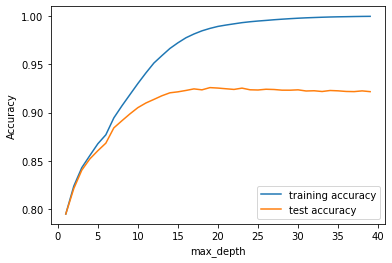

In [88]:
plt.figure()
plt.plot(Scr["param_max_depth"], 
         Scr["mean_train_score"], 
         label="training accuracy")
plt.plot(Scr["param_max_depth"], 
         Scr["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# max_depth around 10 looks optimal

In [89]:
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [90]:
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.495351,0.066838,0.003590,0.000488,5,{'min_samples_leaf': 5},0.887311,0.919023,0.919687,0.917828,...,0.914327,0.013957,1,0.972952,0.965719,0.966216,0.966449,0.966913,0.967650,0.002679
1,1.256169,0.034511,0.003390,0.000489,25,{'min_samples_leaf': 25},0.872445,0.899376,0.904288,0.908270,...,0.898052,0.013131,2,0.929975,0.920917,0.919623,0.920287,0.921415,0.922443,0.003814
2,1.169080,0.019055,0.003536,0.000456,45,{'min_samples_leaf': 45},0.864879,0.892208,0.900305,0.897119,...,0.889981,0.012821,3,0.913879,0.903860,0.904225,0.903926,0.901503,0.905478,0.004312
3,1.096686,0.037063,0.003244,0.000444,65,{'min_samples_leaf': 65},0.859437,0.889685,0.892606,0.893004,...,0.886078,0.013455,4,0.901766,0.897886,0.892842,0.895828,0.895364,0.896737,0.002983
4,1.033653,0.030773,0.003554,0.000756,85,{'min_samples_leaf': 85},0.857314,0.879596,0.889022,0.881322,...,0.880636,0.013035,5,0.896721,0.889855,0.887432,0.888096,0.893041,0.891029,0.003446


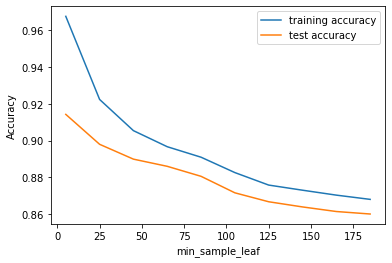

In [91]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# min_sample_leaf =25 is optimal

In [93]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Accuracy 0.8928482414743503
DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50)


In [94]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, random_state=100)

In [95]:
print ('Accuracy Score for Decision Tree :',clf_gini.score(X_test,y_test))
# 85% accuracy on the test dataset
# lots of false positives in the confusion matrix

Accuracy Score for Decision Tree : 0.8512628624883068


In [96]:
#Random Forest

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest',metrics.accuracy_score(y_test, prediction_test))

Randon Forest 0.9394293732460243


In [97]:
print(classification_report(y_test,prediction_test))
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8075
           1       0.47      0.59      0.52       477

    accuracy                           0.94      8552
   macro avg       0.72      0.77      0.74      8552
weighted avg       0.95      0.94      0.94      8552

[[7753  322]
 [ 196  281]]


In [98]:
# GridSearchCV to find optimal n_estimators

# Number of folds for k-fold CV
n_folds = 5

# Parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# Instantiate the model
rf = RandomForestClassifier()

# fit tree on training set
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [101]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.672211,0.043430,0.072316,0.005749,2,{'max_depth': 2},0.812583,0.838975,0.834594,0.842825,...,0.836511,0.013516,4,0.838942,0.841868,0.829589,0.840540,0.838450,0.837878,0.004317
1,6.989926,0.057038,0.112890,0.003929,7,{'max_depth': 7},0.866737,0.885305,0.894332,0.889420,...,0.886715,0.010853,3,0.897617,0.895098,0.894236,0.895497,0.895165,0.895523,0.001127
2,11.340451,0.871331,0.169356,0.010330,12,{'max_depth': 12},0.925405,0.938537,0.944378,0.947033,...,0.940822,0.008451,2,0.971592,0.966150,0.965254,0.966349,0.966515,0.967172,0.002252
3,11.896151,1.379118,0.172614,0.023434,17,{'max_depth': 17},0.944385,0.958051,0.965485,0.962830,...,0.959168,0.007850,1,0.989380,0.987787,0.988982,0.987821,0.987887,0.988371,0.000674


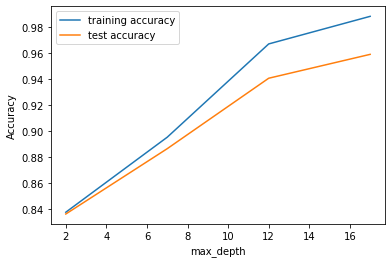

In [104]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
n_folds = 5

parameters = {'n_estimators': range(100, 1500, 400)}

rf = RandomForestClassifier(max_depth=4)

rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)


In [105]:
#Scores
scores = rf.cv_results_
#
## plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
# GridSearchCV to find optimal min_samples_leaf

n_folds = 5
parameters = {'min_samples_leaf': range(50, 400, 10)}
rf = RandomForestClassifier()
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

In [112]:
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
#min_samples_split
n_folds = 5
parameters = {'min_samples_split': range(100, 500, 25)}
rf = RandomForestClassifier()
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
rf.fit(X_lasso, y_tr)

In [ ]:
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#Parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [108]:
grid_search.fit(X_lasso, y_tr)
# optimal accuracy score and hyperparameters
print('Accuracy:',grid_search.best_score_,'by',grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy: 0.8928482414743503 by {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 25, 'min_samples_split': 50}


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [109]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      8075
           1       0.47      0.59      0.52       477

    accuracy                           0.94      8552
   macro avg       0.72      0.77      0.74      8552
weighted avg       0.95      0.94      0.94      8552

[[7753  322]
 [ 196  281]]


In [107]:
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))
#Accuracy Score for Random Forest Final Model : 93%

Accuracy Score for Random Forest Final Model : 0.9394293732460243


In [111]:
# Important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

ValueError: Length of values (34) does not match length of index (59)

In [ ]:
#Local Incoming for Month 8, Average Revenue Per Customer for Month 8 are important predictor variables to predict churn.
#Max Recharge Amount for Month 8 is also important feature to predict churn.


In [ ]:
# Case Study Conclusion :
#Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn.
#Local Incoming and Outgoing Calls for 8th Month and avg revenue in 8th Month are important columns.
#Cutomers with tenure less than 4 yrs are more likely to churn.
#As per our analysis SVM and Random forest produce best accuracy and models can be selected to predict churn data for future.
#Max Recharge Amount is a strong feature to predict churn.